In [2]:
################################################################################################################################
#
# LSTM - JANSEN - FRACDIFF - MINMAX - DAILY
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
#
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [3]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
#===============================================================================================================================
# DATA: INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'LSTM-Jansen-FracDiff-MinMax')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [6]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV-FracDiff'
#ESCALA = 'minmax' 
#EPOCAS = 100
#LOTE = 50
#NEURONS = 32

In [7]:
#===============================================================================================================================
# DATA: READ - FFD
#===============================================================================================================================
df = pd.read_csv('Data/Input/'+seriesId+'.csv')
#df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df

,Close
Date,
2001-10-18,1352.109469
2001-10-19,1738.220882
2001-10-22,2036.189415
2001-10-23,1833.354429
2001-10-24,1661.228961
...,...
2023-12-21,28560.747482
2023-12-22,28708.794508
2023-12-26,29129.784786


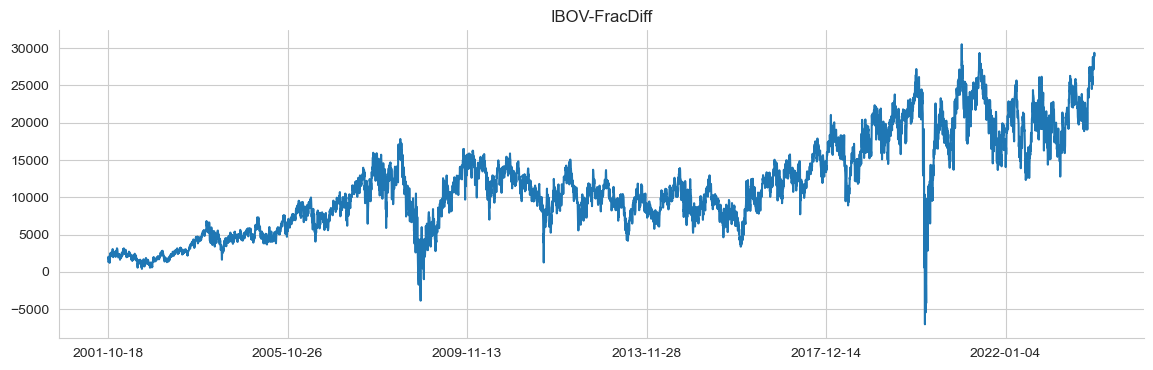

In [8]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [9]:
#===============================================================================================================================
# DATA: SCALE - MINMAX - TRAIN
#===============================================================================================================================
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.Series(scaler.fit_transform(df[:'2023']).squeeze(), index=df[:'2023'].index)
df_scaled

Date
2001-10-18    0.223287
2001-10-19    0.233566
2001-10-22    0.241499
2001-10-23    0.236099
2001-10-24    0.231517
                ...   
2022-12-23    0.746111
2022-12-26    0.704322
2022-12-27    0.699944
2022-12-28    0.743756
2022-12-29    0.718688
Length: 5249, dtype: float64

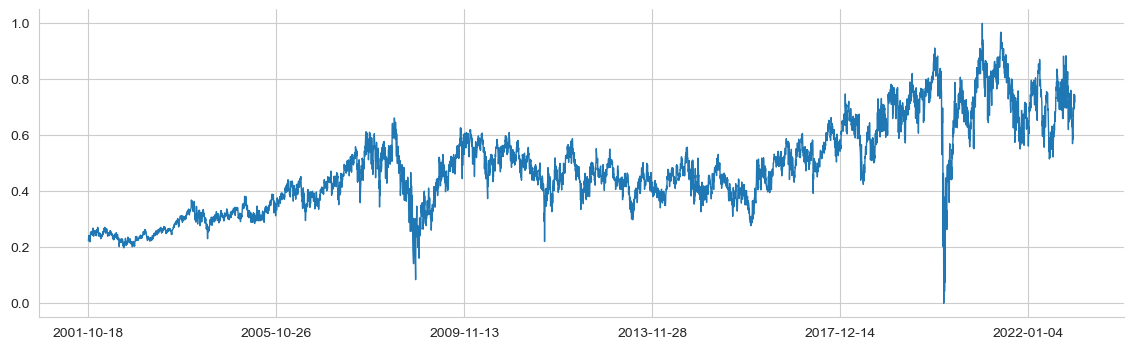

In [10]:
#===============================================================================================================================
# DATA: FRACDIFF - PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [11]:
#===============================================================================================================================
# MODEL: PARAMETERS
#===============================================================================================================================
units=10
window_size=21
batch=20

In [12]:
#===============================================================================================================================
# DATA: MINMAX - SCALE - TEST
#===============================================================================================================================

if window_size==21:
   df_scaledtest = pd.Series(scaler.transform(df['2022-12-01':]).squeeze(), index=df['2022-12-01':].index)
if window_size==63:
   df_scaledtest = pd.Series(scaler.transform(df['2022-09-29':]).squeeze(), index=df['2022-09-29':].index)

print('window_size =', window_size)
df_scaledtest

window_size = 63


Date
2022-09-29    0.659681
2022-09-30    0.731375
2022-10-03    0.882309
2022-10-04    0.841514
2022-10-05    0.850198
                ...   
2023-12-21    0.947637
2023-12-22    0.951578
2023-12-26    0.962786
2023-12-27    0.969536
2023-12-28    0.958684
Length: 311, dtype: float64

In [13]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [14]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - RUN
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X


,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-23,0.223287,0.233566,0.241499,0.236099,0.231517,0.238754,0.238552,0.226728,0.219425,0.231455,...,0.257998,0.246733,0.250230,0.238744,0.239340,0.243457,0.250829,0.250662,0.244410,0.241714
2002-01-24,0.233566,0.241499,0.236099,0.231517,0.238754,0.238552,0.226728,0.219425,0.231455,0.231006,...,0.246733,0.250230,0.238744,0.239340,0.243457,0.250829,0.250662,0.244410,0.241714,0.249284
2002-01-28,0.241499,0.236099,0.231517,0.238754,0.238552,0.226728,0.219425,0.231455,0.231006,0.251399,...,0.250230,0.238744,0.239340,0.243457,0.250829,0.250662,0.244410,0.241714,0.249284,0.246592
2002-01-29,0.236099,0.231517,0.238754,0.238552,0.226728,0.219425,0.231455,0.231006,0.251399,0.252888,...,0.238744,0.239340,0.243457,0.250829,0.250662,0.244410,0.241714,0.249284,0.246592,0.242653
2002-01-30,0.231517,0.238754,0.238552,0.226728,0.219425,0.231455,0.231006,0.251399,0.252888,0.254638,...,0.239340,0.243457,0.250829,0.250662,0.244410,0.241714,0.249284,0.246592,0.242653,0.230543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.800464,0.722423,0.662318,0.661691,0.675489,0.659681,0.731375,0.882309,0.841514,0.850198,...,0.653000,0.600077,0.570099,0.595675,0.603922,0.586580,0.647265,0.697320,0.698163,0.693117
2022-12-26,0.722423,0.662318,0.661691,0.675489,0.659681,0.731375,0.882309,0.841514,0.850198,0.843697,...,0.600077,0.570099,0.595675,0.603922,0.586580,0.647265,0.697320,0.698163,0.693117,0.746111
2022-12-27,0.662318,0.661691,0.675489,0.659681,0.731375,0.882309,0.841514,0.850198,0.843697,0.800699,...,0.570099,0.595675,0.603922,0.586580,0.647265,0.697320,0.698163,0.693117,0.746111,0.704322


In [15]:
#===============================================================================================================================
# DATA PREP: SPLIT
#===============================================================================================================================
X_train = X[:'2023'].values.reshape(-1, window_size, 1)
y_train = y[:'2023']

In [16]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - RUN - TEST
#===============================================================================================================================
Xtest, ytest = create_univariate_rnn_data(df_scaledtest, window_size=window_size)
Xtest

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,0.659681,0.731375,0.882309,0.841514,0.850198,0.843697,0.800699,0.789733,0.760542,0.752424,...,0.586580,0.647265,0.697320,0.698163,0.693117,0.746111,0.704322,0.699944,0.743756,0.718688
2023-01-03,0.731375,0.882309,0.841514,0.850198,0.843697,0.800699,0.789733,0.760542,0.752424,0.697678,...,0.647265,0.697320,0.698163,0.693117,0.746111,0.704322,0.699944,0.743756,0.718688,0.627858
2023-01-04,0.882309,0.841514,0.850198,0.843697,0.800699,0.789733,0.760542,0.752424,0.697678,0.754999,...,0.697320,0.698163,0.693117,0.746111,0.704322,0.699944,0.743756,0.718688,0.627858,0.589606
2023-01-05,0.841514,0.850198,0.843697,0.800699,0.789733,0.760542,0.752424,0.697678,0.754999,0.807017,...,0.698163,0.693117,0.746111,0.704322,0.699944,0.743756,0.718688,0.627858,0.589606,0.642410
2023-01-06,0.850198,0.843697,0.800699,0.789733,0.760542,0.752424,0.697678,0.754999,0.807017,0.806446,...,0.693117,0.746111,0.704322,0.699944,0.743756,0.718688,0.627858,0.589606,0.642410,0.705453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,0.797288,0.724446,0.735721,0.739445,0.696965,0.714105,0.756350,0.772525,0.725708,0.689768,...,0.857175,0.884873,0.872168,0.856075,0.938904,0.954787,0.920036,0.939084,0.949209,0.910370
2023-12-22,0.724446,0.735721,0.739445,0.696965,0.714105,0.756350,0.772525,0.725708,0.689768,0.708189,...,0.884873,0.872168,0.856075,0.938904,0.954787,0.920036,0.939084,0.949209,0.910370,0.947637
2023-12-26,0.735721,0.739445,0.696965,0.714105,0.756350,0.772525,0.725708,0.689768,0.708189,0.703885,...,0.872168,0.856075,0.938904,0.954787,0.920036,0.939084,0.949209,0.910370,0.947637,0.951578


In [17]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - TEST
#===============================================================================================================================
X_test = Xtest['2023':].values.reshape(-1, window_size, 1)
y_test = ytest['2023':]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5186, 63, 1) (5186,) (248, 63, 1) (248,)


In [18]:
#===============================================================================================================================
# DATA PREP: OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(5186, 63, 1)

In [19]:
#===============================================================================================================================
# MODEL: LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=units, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 18)                1440      
                                                                 
 Output (Dense)              (None, 1)                 19        
                                                                 
Total params: 1459 (5.70 KB)
Trainable params: 1459 (5.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
#===============================================================================================================================
# MODEL: CONFIG
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)
#optimizer = keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-07, weight_decay=0.0)
'''
    beta_1=0.9,
    beta_2=0.999,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    loss_scale_factor=None,
    gradient_accumulation_steps=None,
    name="adam",
'''
rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'LSTM-Jansen-FracDiff-MinMax-Daily-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [21]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=batch, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

260/260 [==============================] - ETA: 0s - loss: 0.0047
Epoch 1: val_loss improved from inf to 0.00270, saving model to Data/Output/LSTM-Jansen-FracDiff-MinMax\LSTM-Jansen-FracDiff-MinMax-Daily-rnn.h5
260/260 [==============================] - 12s 32ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 2/150
259/260 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 2: val_loss improved from 0.00270 to 0.00167, saving model to Data/Output/LSTM-Jansen-FracDiff-MinMax\LSTM-Jansen-FracDiff-MinMax-Daily-rnn.h5
260/260 [==============================] - 6s 25ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 3/150
259/260 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 3: val_loss did not improve from 0.00167
260/260 [==============================] - 7s 28ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 4/150
258/260 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 4: val_loss did not improve from 0.00167
260/260 [===================

260/260 [==============================] - 5s 20ms/step - loss: 8.0655e-04 - val_loss: 0.0012
Epoch 68/150
258/260 [============================>.] - ETA: 0s - loss: 8.1327e-04
Epoch 68: val_loss did not improve from 0.00105
260/260 [==============================] - 5s 17ms/step - loss: 8.1083e-04 - val_loss: 0.0013
Epoch 69/150
259/260 [============================>.] - ETA: 0s - loss: 8.0730e-04
Epoch 69: val_loss did not improve from 0.00105
260/260 [==============================] - 5s 17ms/step - loss: 8.0681e-04 - val_loss: 0.0013
Epoch 70/150
258/260 [============================>.] - ETA: 0s - loss: 8.0988e-04
Epoch 70: val_loss did not improve from 0.00105
260/260 [==============================] - 5s 18ms/step - loss: 8.1039e-04 - val_loss: 0.0015
Epoch 71/150
258/260 [============================>.] - ETA: 0s - loss: 7.9967e-04
Epoch 71: val_loss did not improve from 0.00105
260/260 [==============================] - 5s 19ms/step - loss: 8.0275e-04 - val_loss: 0.0011
Epoch 

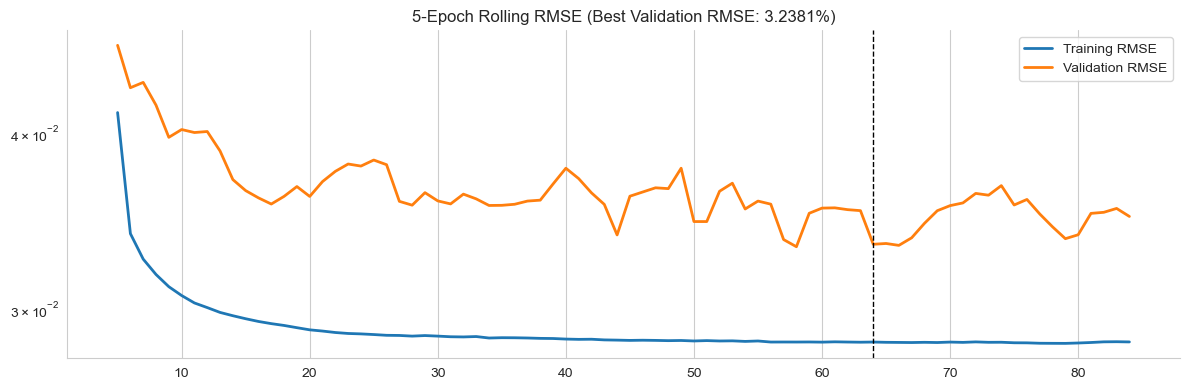

In [22]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

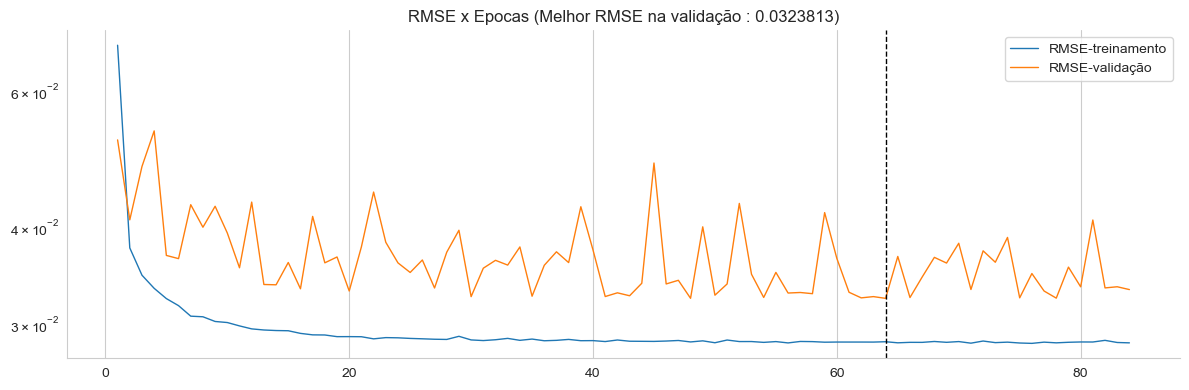

In [23]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [24]:
#===============================================================================================================================
# RESULTS - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.0277 | Test RMSE: 0.0324
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.0283 | Test RMSE: 0.0324


In [25]:
#===============================================================================================================================
# RESULTS - FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

8/8 [==============================] - 0s 4ms/step


In [26]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.5f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.985565 | Test IC: 0.92914
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: 0.985295 | Test IC: 0.92873


In [27]:
#===============================================================================================================================
# RESULTS - FORECAST - RESULTS
#===============================================================================================================================
np.savetxt('Data/Output/LSTM-Jansen-FracDiff-MinMax-Daily-Scaled-Test.txt', test_predict_scaled, delimiter=';')
test_predict_scaled[:,0]

array([0.7211069 , 0.65533143, 0.61751014, 0.64695287, 0.6959044 ,
       0.72026277, 0.7191497 , 0.748158  , 0.7758815 , 0.7558837 ,
       0.7340895 , 0.7007518 , 0.7464683 , 0.76003087, 0.76983047,
       0.7483789 , 0.7408974 , 0.7654447 , 0.78674066, 0.7799753 ,
       0.7403403 , 0.7403258 , 0.7636514 , 0.735669  , 0.69916064,
       0.6719465 , 0.6813257 , 0.6682717 , 0.7130321 , 0.6751256 ,
       0.6784597 , 0.69515866, 0.676779  , 0.7123552 , 0.7178931 ,
       0.7014916 , 0.6628961 , 0.6751026 , 0.6438265 , 0.6467699 ,
       0.6360308 , 0.62974703, 0.6137116 , 0.6287307 , 0.64812696,
       0.6403862 , 0.686224  , 0.65616286, 0.6288396 , 0.6226417 ,
       0.6232261 , 0.6220952 , 0.6398136 , 0.6137291 , 0.59651923,
       0.60228974, 0.59159774, 0.5524862 , 0.57546294, 0.59662414,
       0.6280888 , 0.6392856 , 0.6745963 , 0.6358926 , 0.62847257,
       0.6370977 , 0.6215459 , 0.6207379 , 0.64257485, 0.7273412 ,
       0.7331054 , 0.7169231 , 0.7088653 , 0.70148534, 0.70341

In [28]:
#===============================================================================================================================
# RESULTS - FRACDIFF - RECOVER - PRED - TRAIN, TEST
#===============================================================================================================================
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))

np.savetxt('Data/Output/LSTM-Jansen-FracDiff-MinMax-Daily-Train.txt', train_predict, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-FracDiff-MinMax-Daily-Test.txt' , test_predict , delimiter=';')

test_predict

Date
2023-01-02    20051.636719
2023-01-03    17580.921875
2023-01-04    16160.246094
2023-01-05    17266.199219
2023-01-06    19104.957031
                  ...     
2023-12-21    27145.181641
2023-12-22    28086.480469
2023-12-26    28301.023438
2023-12-27    28662.748047
2023-12-28    28907.984375
Length: 248, dtype: float32

In [29]:
#===============================================================================================================================
# RESULTS - FRACDIFF - RECOVER - TARGET - TRAIN, TEST
#===============================================================================================================================
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

y_test_rescaled

array([16548.9486494 , 15112.08589238, 17095.53824067, 19463.64369831,
       20319.88163955, 20031.13724526, 21501.23903543, 22669.81694135,
       21352.19497411, 20284.32938683, 18683.76510605, 21319.17823985,
       21684.03348622, 22035.037179  , 20821.18808584, 20567.16972093,
       21900.21079595, 22810.23479997, 22268.07070387, 20221.30195775,
       20511.86752773, 21755.98977796, 20137.90481114, 18440.22553165,
       17364.46504156, 18168.84967708, 17493.7005381 , 19982.1103913 ,
       17698.0215855 , 18179.72401629, 19081.27034205, 18000.02283192,
       19996.93963377, 20010.50002777, 19070.07671467, 17163.57169673,
       18140.37409857, 16443.49608395, 16884.72650006, 16358.21769438,
       16161.28298076, 15425.15253933, 16411.99912423, 17343.78775201,
       16776.37512216, 19225.67765895, 17264.43000271, 16028.41296089,
       15962.9564427 , 16079.48107127, 16033.19066577, 16989.40112556,
       15472.59287807, 14800.63639949, 15313.13614659, 14735.1266281 ,
      

In [30]:
#===============================================================================================================================
# RESULTS - FRACDIFF - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'
#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE: 1053.46 | Test RMSE: 1171.87'
#-------------------------------------------------------------------------------------------------------------------------------

'Train RMSE: 1063.99 | Test RMSE: 1216.33'

In [31]:
#===============================================================================================================================
# RESULTS - FRACDIFF - STORE - TRAIN, TEST
#===============================================================================================================================
df['Train Predictions'] = train_predict
df['Test Predictions'] = test_predict

temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])
df['predictions'] = temp['predictions']
df['data']        = temp[ 'data']

df['2022-12-29':]

,Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2022-12-29,19960.780669,20520.810547,NaN,20520.810547,Train
2023-01-02,16548.948649,NaN,20051.636719,20051.636719,Test
2023-01-03,15112.085892,NaN,17580.921875,17580.921875,Test
2023-01-04,17095.538241,NaN,16160.246094,16160.246094,Test
2023-01-05,19463.643698,NaN,17266.199219,17266.199219,Test
...,...,...,...,...,...
2023-12-21,28560.747482,NaN,27145.181641,27145.181641,Test
2023-12-22,28708.794508,NaN,28086.480469,28086.480469,Test
2023-12-26,29129.784786,NaN,28301.023438,28301.023438,Test


In [32]:
#===============================================================================================================================
# RESULTS - FRACDIFF - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-FracDiff-MinMax-Daily.xlsx')

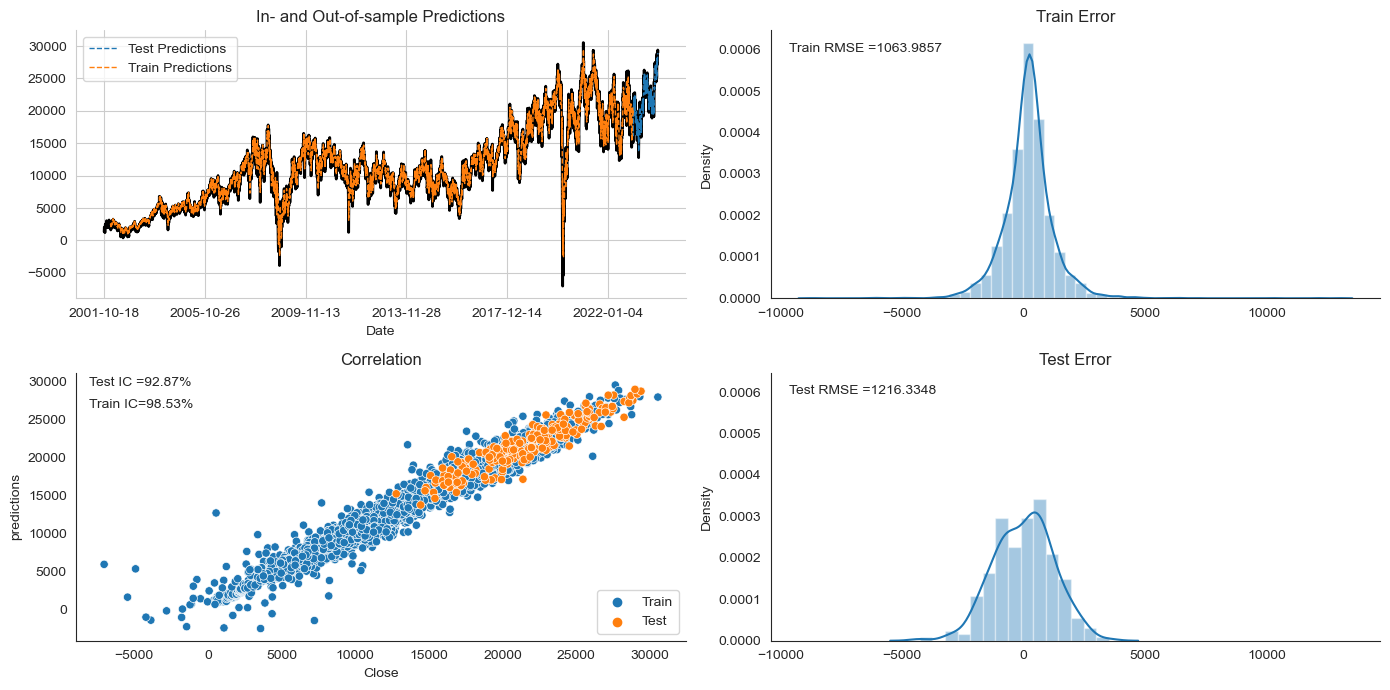

In [33]:
#===============================================================================================================================
# RESULTS - FRACDIFF - PLOT
#===============================================================================================================================
fig=plt.figure(figsize=(14,7))

ax1 = plt.subplot(221)
df.loc['2000':, 'Close'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Close', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);


In [34]:
#===============================================================================================================================
# FRACDIFF: RECOVER - PRICES - d, THRESHOLD
#===============================================================================================================================
d=0.2485
THRESHOLD=1e-4

In [35]:
#===============================================================================================================================
# FRACDIFF: RECOVER - FUNCTION WEIGHTS
#===============================================================================================================================
def getWeights_FFD(d, thres=THRESHOLD, lim=10000):
    w, k = [1.], 1                          # Set w as a list and k as one
    ctr = 0                                 # Set ctr
    while True:                             # Loop While
        w_ = -w[-1] / k * (d - k + 1)          # Create the new weight value
        if abs(w_) < thres:break               # End the loop in case the threshold is breached
        w.append(w_)                           # Append the new value of w
        k += 1                                 # Increment k
        ctr += 1                               # Increment ctr
        if ctr == lim - 1:break                # End the loop in case it breaches the limit
    return np.array(w[::-1]).reshape(-1, 1) # Convert the w from list to a numpy array

In [36]:
#===============================================================================================================================
# FRACDIFF: RECOVER - WEIGHTS
#===============================================================================================================================
#w_FFD = getWeights_FFD(d, thres=1e-6, lim=5942-446+1)
w_FFD = getWeights_FFD(d, thres=1e-6, lim=248)
print(len(w_FFD[:-1]))
w_FFD[:]

247


array([[-2.09285730e-04],
       [-2.10348971e-04],
       [-2.11421981e-04],
       [-2.12504888e-04],
       [-2.13597826e-04],
       [-2.14700930e-04],
       [-2.15814335e-04],
       [-2.16938183e-04],
       [-2.18072615e-04],
       [-2.19217776e-04],
       [-2.20373812e-04],
       [-2.21540875e-04],
       [-2.22719116e-04],
       [-2.23908690e-04],
       [-2.25109756e-04],
       [-2.26322476e-04],
       [-2.27547012e-04],
       [-2.28783533e-04],
       [-2.30032207e-04],
       [-2.31293210e-04],
       [-2.32566717e-04],
       [-2.33852908e-04],
       [-2.35151966e-04],
       [-2.36464079e-04],
       [-2.37789437e-04],
       [-2.39128233e-04],
       [-2.40480666e-04],
       [-2.41846937e-04],
       [-2.43227252e-04],
       [-2.44621820e-04],
       [-2.46030854e-04],
       [-2.47454573e-04],
       [-2.48893199e-04],
       [-2.50346958e-04],
       [-2.51816081e-04],
       [-2.53300804e-04],
       [-2.54801368e-04],
       [-2.56318018e-04],
       [-2.5

In [37]:
#===============================================================================================================================
# PREDICTION FFD: y_pred_fracdiff
#===============================================================================================================================
#y_pred_fracdiff=df.loc['2023-01-31':,'predictions'].to_frame()
y_pred_fracdiff=df['predictions'].to_frame()
y_pred_fracdiff.rename(columns={'predictions':'Residuals'}, inplace=True)
y_pred_fracdiff[-248:]


,Residuals
Date,
2023-01-02,20051.636719
2023-01-03,17580.921875
2023-01-04,16160.246094
2023-01-05,17266.199219
2023-01-06,19104.957031
...,...
2023-12-21,27145.181641
2023-12-22,28086.480469
2023-12-26,28301.023438


In [38]:
#===============================================================================================================================
# DATA: READ - PRICES - ORI
#===============================================================================================================================
seriesId = 'IBOV'
df_temp = pd.read_csv(seriesId+'.csv')

df_test_ori = df_temp.copy()
df_test_ori['Date'] = pd.to_datetime(df_test_ori['Date'], dayfirst=True)
df_test_ori = df_test_ori.loc[:, ['Date', 'Close']]
df_test_ori = df_test_ori.set_index('Date')
#df_test_ori = df_test_ori['2023-01-01':]
df_test_ori = df_test_ori['2022-01-06':]
df_test_ori

,Close
Date,
2022-01-06,101561.05
2022-01-07,102719.47
2022-01-10,101945.20
2022-01-11,103778.98
2022-01-12,105685.66
...,...
2023-12-21,132182.01
2023-12-22,132752.93
2023-12-26,133532.92


In [39]:
#===============================================================================================================================
# DATA: RECOVER - FRACDIFF - FUNCTION
#===============================================================================================================================
def fracDiff_FFD_recover(series_ffd,d,thres=THRESHOLD, w=None,series_ori=None):

    width=len(w)
    
    df= {}
    prices_ori,df_=series_ori, pd.Series() 
    
    print('width = ',width)
    print('')
    #---------------------------------------------------------------------------------------------------------------------------
    # Loop W
    #---------------------------------------------------------------------------------------------------------------------------
    for iloc1 in range(0,width):
        print('-------------------------------------------------')
        #-----------------------------------------------------------------------------------------------------------------------
        # loc0, loc1
        #-----------------------------------------------------------------------------------------------------------------------
        loc0=prices_ori.index[iloc1]
        loc1=prices_ori.index[iloc1-width-1]
        locffd0=series_ffd.index[iloc1]

        print('')
        print('Loop: iloc1=', iloc1, ' | loc0=', loc0, ' | loc1=', loc1, ' | locffd0=', locffd0)

        if not (np.isfinite(series_ori.loc[loc1])).any():continue

        print('')
        print('w[iloc1]           = ', np.round(w[iloc1],6))
        print('series_ori[loc0]   = ', series_ori.loc[loc0,'Close'])
        print('series_ori[loc1]   = ', series_ori.loc[loc1,'Close'])
        print('series_ffd[locffd0]= ', series_ffd.loc[locffd0,'Residuals'])
            
        #-----------------------------------------------------------------------------------------------------------------------
        # Dot Product w x series_ori[loc0:loc1]
        #-----------------------------------------------------------------------------------------------------------------------
        print('')
        df_[loc1]=np.dot(w[:-1].T,series_ori.loc[loc0:loc1])[0]
        print('dot(w, series_ori  = ', df_[loc1])
        df_[loc1]=np.round(series_ffd.loc[locffd0,'Residuals'] - df_[loc1],2)
        print('Pred               = ', df_[loc1])

    df['Close']=df_.copy(deep=True)
    df=pd.concat(df,axis=1)

    return df

In [40]:
#===============================================================================================================================
# FRACDIFF: RECOVER - PRICES - RUN FRACDIFF RECOVER
#===============================================================================================================================
test_predict_recover_price = fracDiff_FFD_recover(y_pred_fracdiff[-248:], d, THRESHOLD, w_FFD[:], df_test_ori)

width =  248

-------------------------------------------------

Loop: iloc1= 0  | loc0= 2022-01-06 00:00:00  | loc1= 2022-12-29 00:00:00  | locffd0= 2023-01-02

w[iloc1]           =  [-0.000209]
series_ori[loc0]   =  101561.05
series_ori[loc1]   =  109734.6
series_ffd[locffd0]=  20051.637

dot(w, series_ori  =  [-86562.71579901]
Pred               =  106614.35
-------------------------------------------------

Loop: iloc1= 1  | loc0= 2022-01-07 00:00:00  | loc1= 2023-01-02 00:00:00  | locffd0= 2023-01-03

w[iloc1]           =  [-0.00021]
series_ori[loc0]   =  102719.47
series_ori[loc1]   =  106376.02
series_ffd[locffd0]=  17580.922

dot(w, series_ori  =  [-85792.10248939]
Pred               =  103373.02
-------------------------------------------------

Loop: iloc1= 2  | loc0= 2022-01-10 00:00:00  | loc1= 2023-01-03 00:00:00  | locffd0= 2023-01-04

w[iloc1]           =  [-0.000211]
series_ori[loc0]   =  101945.2
series_ori[loc1]   =  104165.74
series_ffd[locffd0]=  16160.246

dot(w, s

dot(w, series_ori  =  [-83995.42598234]
Pred               =  104417.35
-------------------------------------------------

Loop: iloc1= 89  | loc0= 2022-05-17 00:00:00  | loc1= 2023-05-11 00:00:00  | locffd0= 2023-05-12

w[iloc1]           =  [-0.000366]
series_ori[loc0]   =  108789.33
series_ori[loc1]   =  108256.4
series_ffd[locffd0]=  20842.781

dot(w, series_ori  =  [-84373.75710878]
Pred               =  105216.54
-------------------------------------------------

Loop: iloc1= 90  | loc0= 2022-05-18 00:00:00  | loc1= 2023-05-12 00:00:00  | locffd0= 2023-05-15

w[iloc1]           =  [-0.000369]
series_ori[loc0]   =  106247.15
series_ori[loc1]   =  108463.84
series_ffd[locffd0]=  20828.963

dot(w, series_ori  =  [-84624.09370615]
Pred               =  105453.06
-------------------------------------------------

Loop: iloc1= 91  | loc0= 2022-05-19 00:00:00  | loc1= 2023-05-15 00:00:00  | locffd0= 2023-05-16

w[iloc1]           =  [-0.000372]
series_ori[loc0]   =  107005.22
series_ori

Pred               =  112850.92
-------------------------------------------------

Loop: iloc1= 165  | loc0= 2022-09-01 00:00:00  | loc1= 2023-08-28 00:00:00  | locffd0= 2023-08-29

w[iloc1]           =  [-0.00083]
series_ori[loc0]   =  110405.3
series_ori[loc1]   =  117120.98
series_ffd[locffd0]=  22079.969

dot(w, series_ori  =  [-91999.23365715]
Pred               =  114079.2
-------------------------------------------------

Loop: iloc1= 166  | loc0= 2022-09-02 00:00:00  | loc1= 2023-08-29 00:00:00  | locffd0= 2023-08-30

w[iloc1]           =  [-0.000843]
series_ori[loc0]   =  110864.24
series_ori[loc1]   =  118403.61
series_ffd[locffd0]=  22994.12

dot(w, series_ori  =  [-92383.99930357]
Pred               =  115378.12
-------------------------------------------------

Loop: iloc1= 167  | loc0= 2022-09-05 00:00:00  | loc1= 2023-08-30 00:00:00  | locffd0= 2023-08-31

w[iloc1]           =  [-0.000856]
series_ori[loc0]   =  112203.35
series_ori[loc1]   =  117535.1
series_ffd[locffd0]

In [41]:
#===============================================================================================================================
# PRICES: RECOVER - PRED
#===============================================================================================================================
test_predict_recover_price

,Close
2022-12-29,106614.35
2023-01-02,103373.02
2023-01-03,101140.04
2023-01-04,102187.16
2023-01-05,104493.95
...,...
2023-12-20,127661.1
2023-12-21,129025.66
2023-12-22,129599.45
2023-12-26,130368.22


In [42]:
#===============================================================================================================================
# PRICES: READ - CLOSE
#===============================================================================================================================
dfPrices = pd.read_csv('IBOV.csv')
dfPrices['Date'] = pd.to_datetime(dfPrices['Date'], dayfirst=True)
dfPrices.set_index('Date', inplace=True)

dfPricesTest = dfPrices.loc['2023-01-01':,'Close'].to_frame()
dfPricesTest

,Close
Date,
2023-01-02,106376.02
2023-01-03,104165.74
2023-01-04,105334.46
2023-01-05,107641.32
2023-01-06,108963.70
...,...
2023-12-21,132182.01
2023-12-22,132752.93
2023-12-26,133532.92


In [43]:
#===============================================================================================================================
# PRICES: PERFORMANCE - PRICE
#===============================================================================================================================
#train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(dfPricesTest, test_predict_recover_price))
#print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Test RMSE: 3399.02
#-------------------------------------------------------------------------------------------------------------------------------

Test RMSE: 3348.64
